In [1]:
import torch
import os
import h5py
import preprocess
import numpy as np
import matplotlib.pyplot as plt
from utils import SequenceDataset, plot_sample
from tqdm import tqdm
from torch.utils.data import DataLoader
from torch import nn, optim
from pathlib import Path
# Import the necessary classes
from score import ScoreUNet
from score import VPSDE
from score import GaussianScore
import importlib
import score
importlib.reload(score)

<module 'score' from '/home/mtemoschenko/TFE/score.py'>

In [3]:
checkpoint_path = "slurm/checkpoints/attention_config_spatial_T2m_U10m_2000_2014/attention_config_spatial_T2m_U10m_2000_2014_310.pth"

In [5]:
import importlib
import score
importlib.reload(score)
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

PATH_DATA = Path('./data/processed')
# Load mask
with h5py.File(PATH_DATA / "mask.h5", "r") as f:
    mask = torch.tensor(f["dataset"][:], dtype=torch.float32, device=device).unsqueeze(0)
    mask_cpu = mask.detach().clone().cpu()
if torch.isnan(mask).any():
    raise ValueError("Mask contains NaN values!")
window = 12
# Load dataset to get dimensions
testset = SequenceDataset(PATH_DATA / "test.h5", window=window, flatten=True)

channels, y_dim, x_dim = testset[0][0].shape
print(f"Channels : {channels}")

TRAIN_CONFIG = {
    "epochs": 10000,
    "batch_size": 5,
    "learning_rate": 2e-4,
    "weight_decay": 1e-4,
    "scheduler": "cosine",
    "embedding": 64,
    "activation": "SiLU",
    "eta": 5e-3,
}
MODEL_CONFIG = { 'hidden_channels' : [64, 128,128,256],
'attention_levels' : [2],
'hidden_blocks' : [2,3,3,3],
'spatial' : 2,
'channels' : channels,
'context' : 4,
'embedding' : 64 }

Using device: cuda
Spatial Encoding Shape : torch.Size([4, 64, 64])
Channels : 24


In [47]:
batch_size = TRAIN_CONFIG['batch_size']
testloader = DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=1, persistent_workers=True)
# Initialize ScoreUNet and VPSDE
score_unet = ScoreUNet(**MODEL_CONFIG).to(device)
vpsde = VPSDE(score_unet, shape=(channels, y_dim, x_dim), eta = TRAIN_CONFIG["eta"]).to(device)
# Load checkpoint
checkpoint = torch.load(checkpoint_path, map_location=device)
vpsde.load_state_dict(checkpoint['model_state_dict'])
print(f"Model restored from {checkpoint_path}, trained until epoch {checkpoint['epoch']}")

/tmp/ipykernel_128340/3784321478.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


Model restored from slurm/checkpoints/attention_config_spatial_T2m_U10m_2000_2014/attention_config_spatial_T2m_U10m_2000_2014_310.pth, trained until epoch 310


<h3>Playgound</h3>

In [70]:
weather_station = (torch.rand(64,64) < 0.05) * mask_cpu
weather_station  = weather_station.to(device)

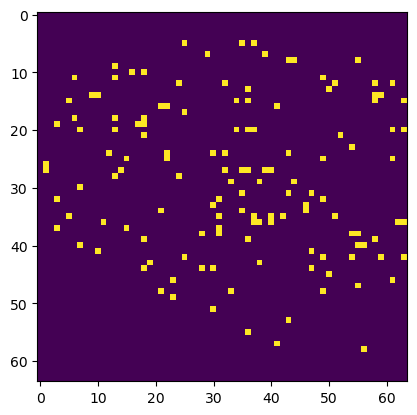

In [71]:
plt.imshow(weather_station[0].detach().cpu())
plt.show()

In [65]:
batch, dic = next(iter(testloader))
batch = batch.cpu()


In [66]:
sparsed_batch = batch * weather_station

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

torch.Size([5, 24, 64, 64])
T2m  Mean : 21.146821975708008, Var: 4.204456806182861
U10m  Mean : 2.679358720779419, Var: 0.9211068749427795
T2m  Mean : 16.540433883666992, Var: 3.0077853202819824
U10m  Mean : 2.1702656745910645, Var: 0.707478404045105
T2m  Mean : 1.3637892007827759, Var: 1.5171042680740356
U10m  Mean : 4.043972015380859, Var: 1.2426542043685913


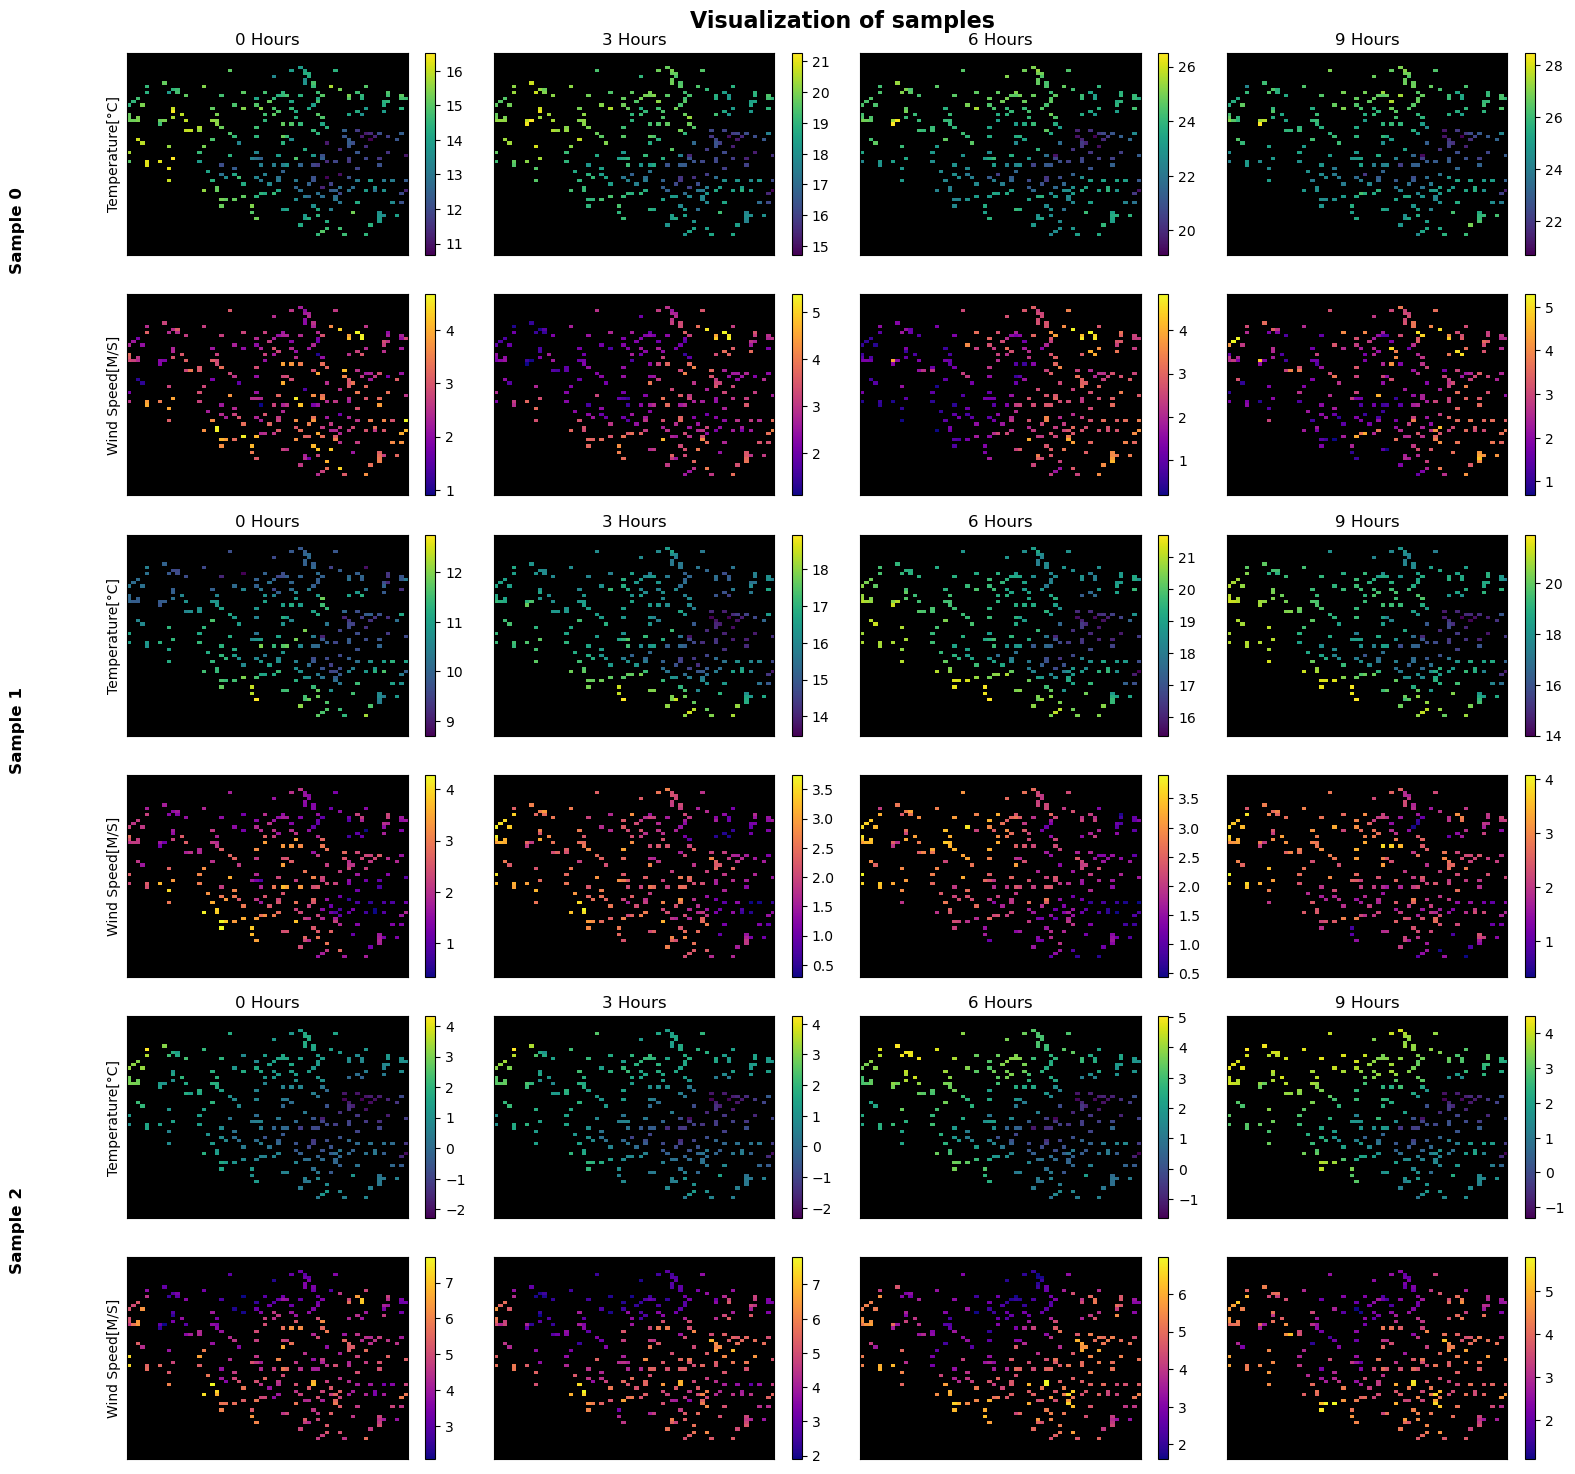

In [44]:
path_unnorm = PATH_DATA/ "train.h5"
info  = {'var_index': ['T2m', 'U10m'], 'channels' : 2, 'window' : 12}
fig = plot_sample(sparsed_batch,info,weather_station,samples=3,step=3, unnormalize=True, path_unnorm = path_unnorm)

In [72]:
def sparse_belgium(batch, mask):
    return batch*mask
def A(x):
    return sparse_belgium(x, weather_station)

torch.Size([5, 24, 64, 64])
T2m  Mean : 9.69862174987793, Var: 0.9625032544136047
U10m  Mean : 5.8576507568359375, Var: 1.7824482917785645
T2m  Mean : 18.28004264831543, Var: 1.8446729183197021
U10m  Mean : 4.1062750816345215, Var: 1.7414129972457886
T2m  Mean : 10.855894088745117, Var: 1.3093675374984741
U10m  Mean : 6.997805118560791, Var: 2.1096701622009277


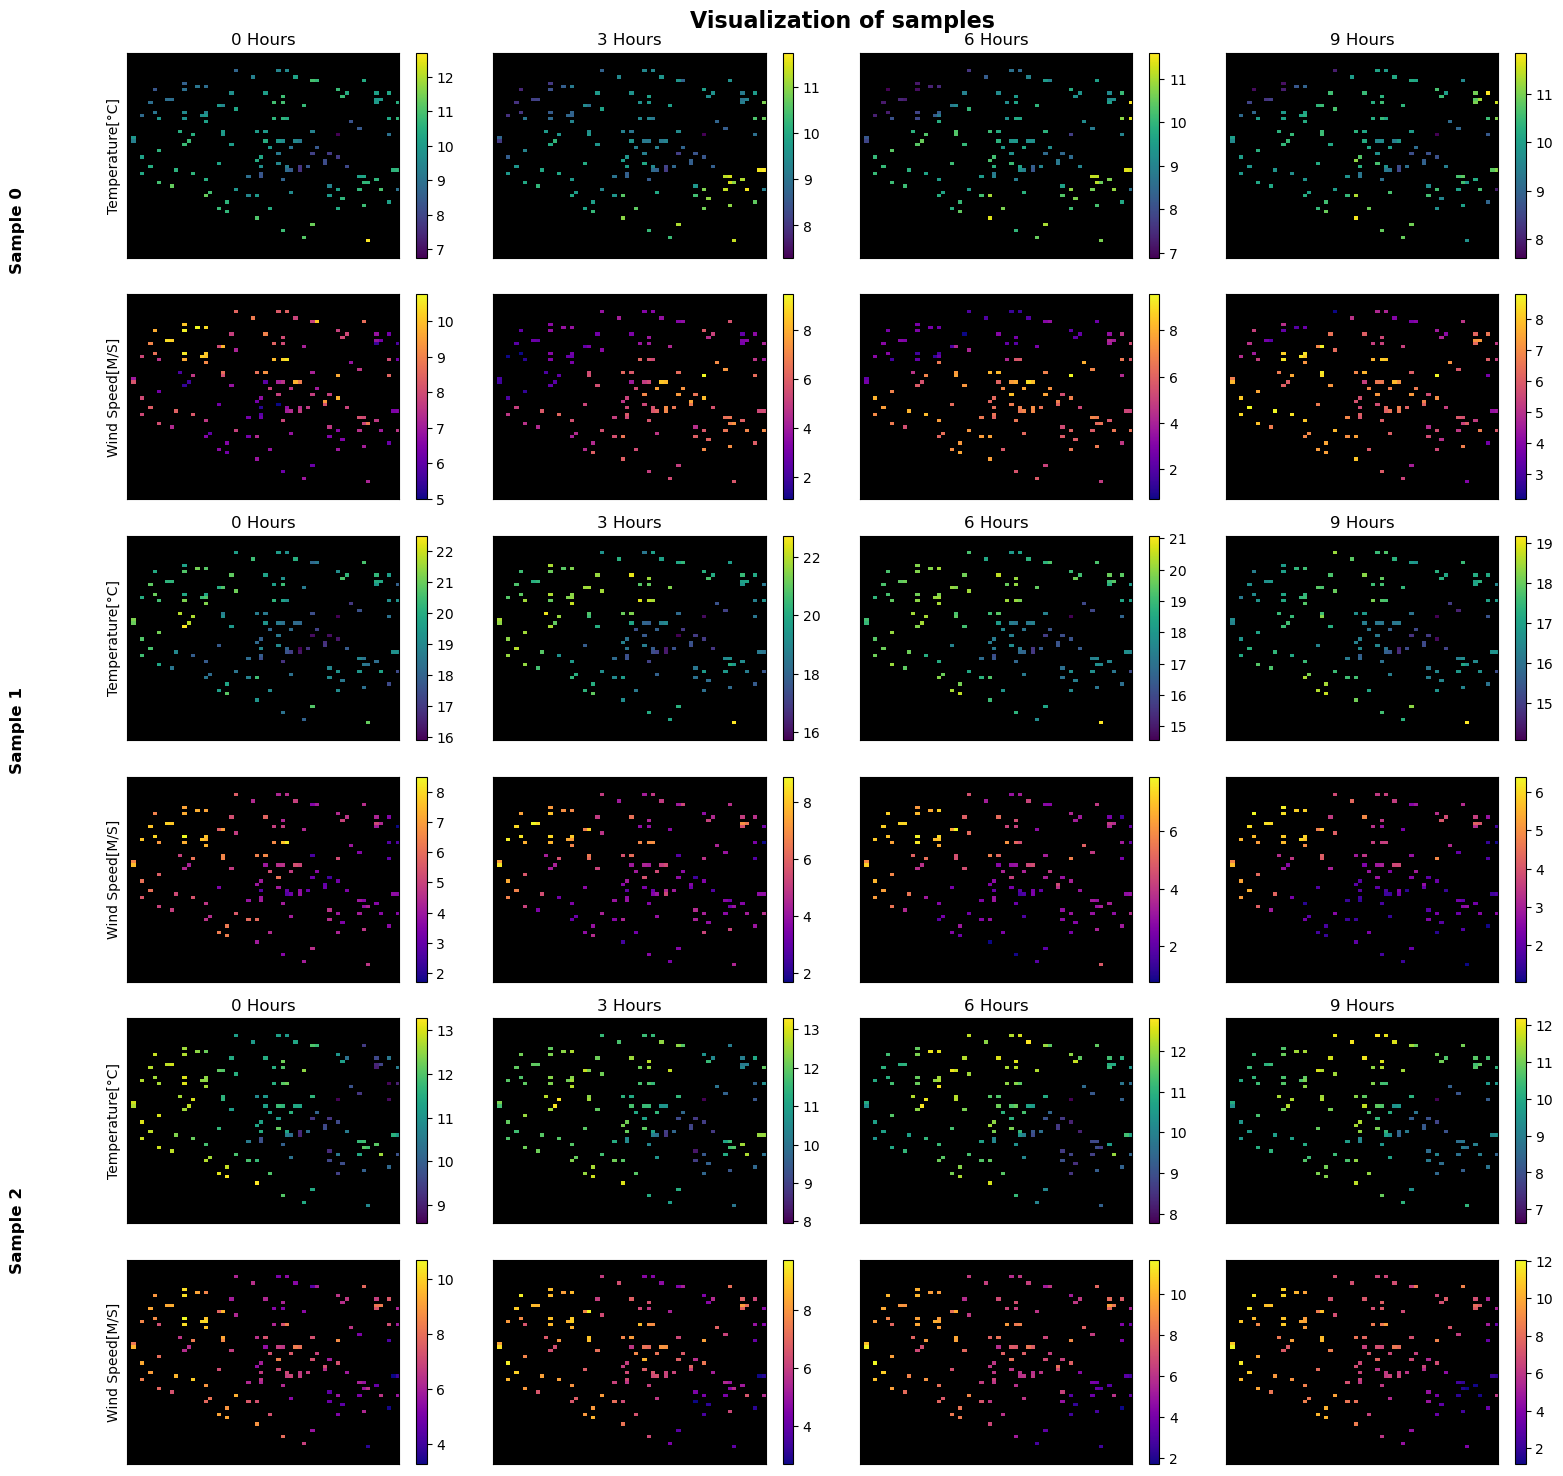

In [73]:
x_star, c_star = next(iter(testloader))
x_star = x_star.to(device)
c_star = c_star['context'].to(device)
y_star = torch.normal(A(x_star), 1e-2)*mask

info  = {'var_index': ['T2m', 'U10m'], 'channels' : 2, 'window' : 12}
fig = plot_sample(y_star.detach().cpu(),info,weather_station.detach().cpu(),samples=3,step=3, unnormalize=True, path_unnorm = path_unnorm)

In [74]:
importlib.reload(score)
sde = VPSDE(score.DPSGaussianScore(y_star,mask, A=A,  sde=vpsde, zeta=4.9), shape=x_star.shape).cuda()

In [75]:
x = sde.sample(mask,shape=(1,), c=c_star, steps=64, corrections=8, tau=0.5).cpu()


100%|███████████████████████████████████████████████████| 64/64 [00:19<00:00,  3.34it/s]


torch.Size([15, 24, 64, 64])
T2m  Mean : 9.762701988220215, Var: 0.9671334624290466
U10m  Mean : 5.8389787673950195, Var: 1.7902295589447021
T2m  Mean : 10.35680866241455, Var: 0.26563605666160583
U10m  Mean : 4.094249725341797, Var: 0.5531632900238037
T2m  Mean : 9.333089828491211, Var: 1.0629277229309082
U10m  Mean : 6.19575834274292, Var: 1.4868606328964233
T2m  Mean : 18.329790115356445, Var: 1.8176347017288208
U10m  Mean : 4.054410457611084, Var: 1.6687449216842651
T2m  Mean : 10.764993667602539, Var: 1.7259457111358643
U10m  Mean : 4.011118412017822, Var: 0.3804410398006439
T2m  Mean : 16.996816635131836, Var: 2.173705577850342
U10m  Mean : 4.484848499298096, Var: 1.6238317489624023
T2m  Mean : 10.845498085021973, Var: 1.3181551694869995
U10m  Mean : 6.879415512084961, Var: 2.1336069107055664
T2m  Mean : 10.412094116210938, Var: 0.3103387951850891
U10m  Mean : 4.148315906524658, Var: 0.784784734249115
T2m  Mean : 9.14484977722168, Var: 1.5942193269729614
U10m  Mean : 7.0037508010

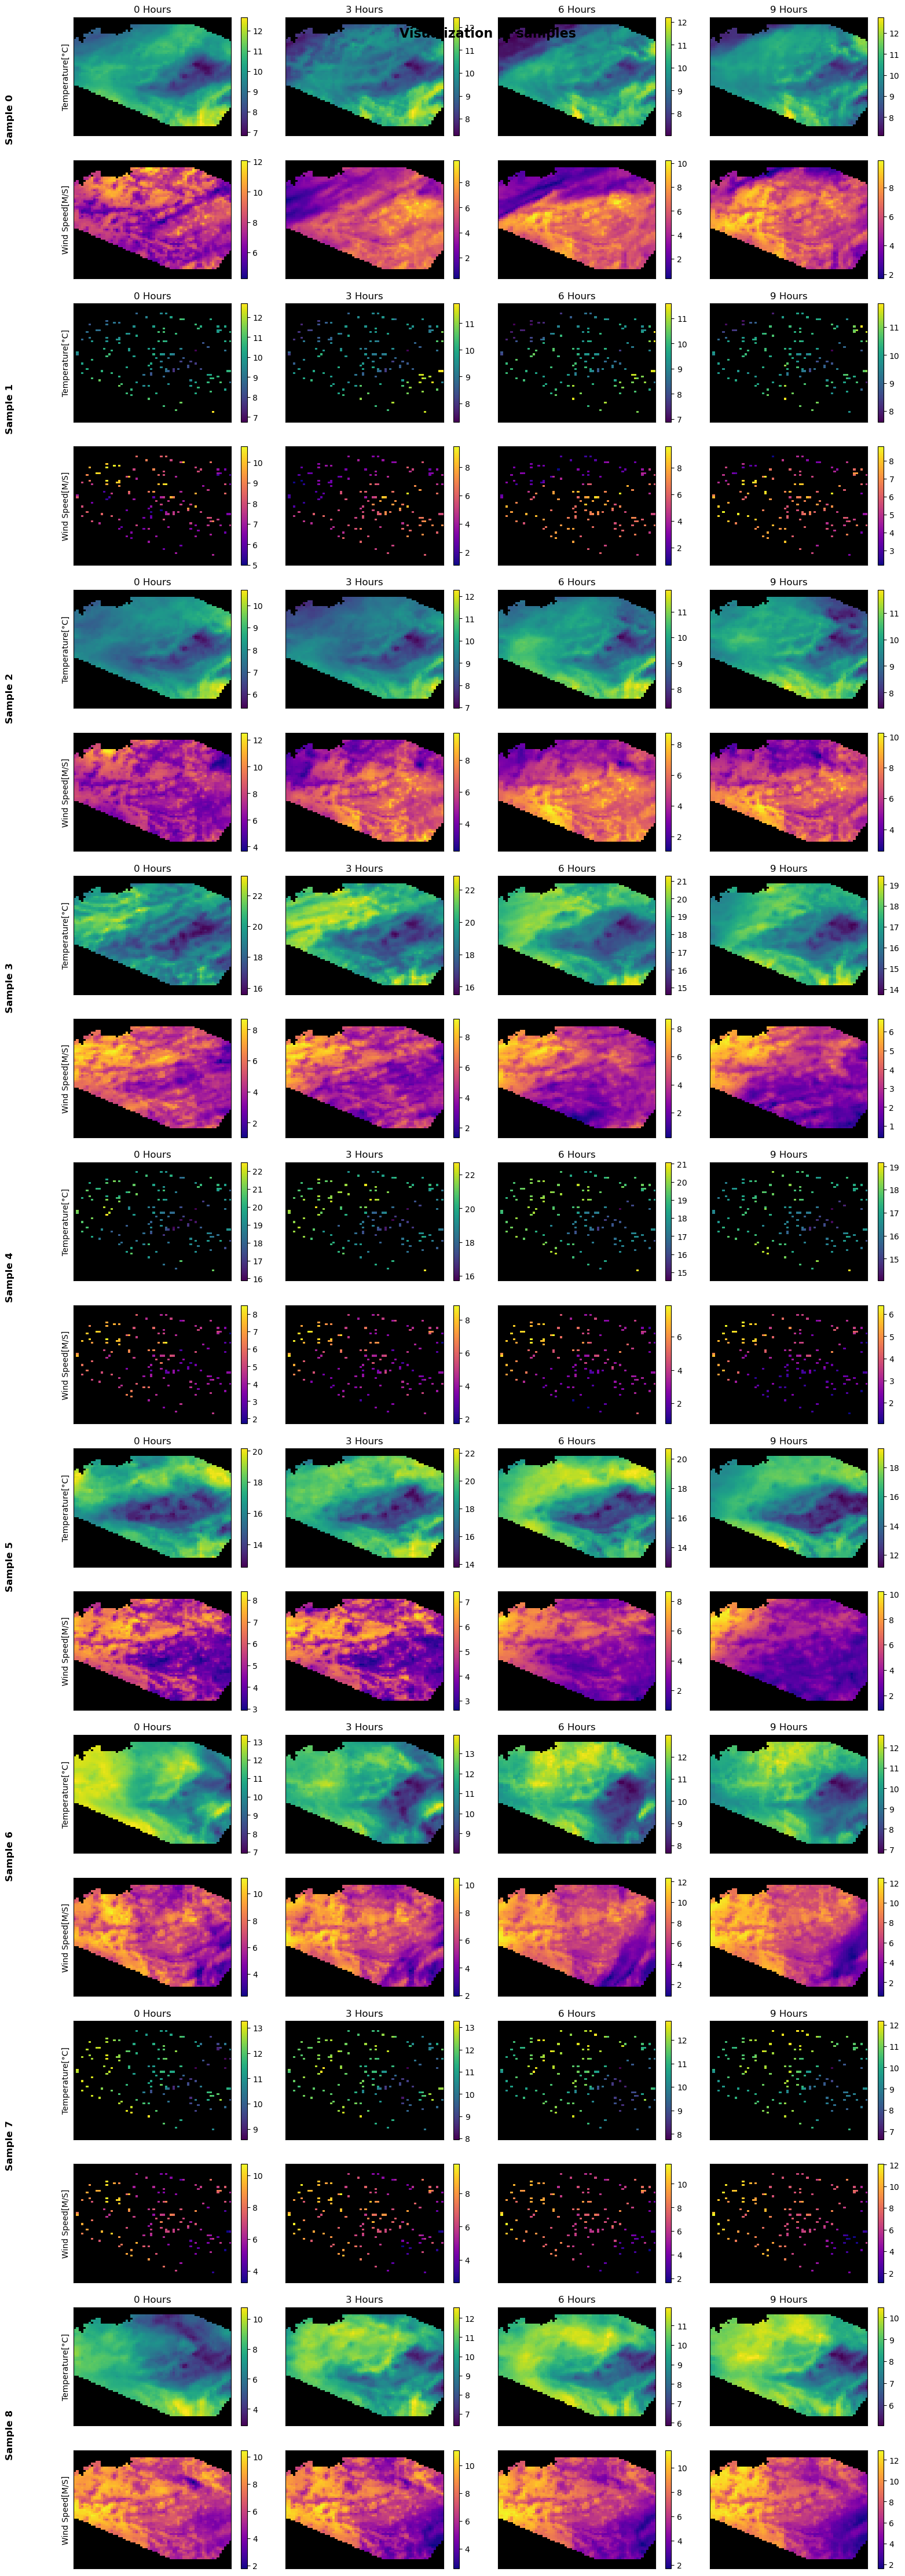

In [76]:
x_ = x[0]
# Good parameters : zeta: 4.5, steps: 48, corrections: 3
# Good parameters : zeta= 4.7, steps = 64, corrections = 8, tau = 0.5
new_tensor = torch.stack((x_star.detach().cpu(),y_star.detach().cpu(),x_), dim=1).flatten(0,1).cpu()
path_unnorm = PATH_DATA/ "train.h5"
info  = {'var_index': ['T2m', 'U10m'], 'channels' : 2, 'window' : 12}
fig = plot_sample(new_tensor,info,mask_cpu,samples=9,step=3, unnormalize=True, path_unnorm = path_unnorm)

In [58]:
def plot_sample(batch,info,mask, samples, step=4, unnormalize=True, path_unnorm = 'data/norm_params.h5'):
    print(batch.shape)
    B, Z, Y , X = batch.shape
    redim_batch = batch.view(B, info['window'], info['channels'], Y,X).permute(0, 2, 1, 3, 4)
    if unnormalize == True:
        for i in range(info['channels']):
            redim_batch[:,i, ...] = preprocess.unnormalize_ds(redim_batch[:,i, ...], info['var_index'][i], normfile_path=path_unnorm ,normalization_mode='zscore')
    traj= torch.where(mask.unsqueeze(0).unsqueeze(0).bool(), redim_batch, torch.tensor(float('nan'), dtype=redim_batch.dtype))
    data = traj
    s, variables, timesteps, y_dim, x_dim = data.shape
    selected_timesteps = range(0, timesteps, step)
    fig, axes = plt.subplots(nrows=info['channels'] * samples, ncols=len(selected_timesteps), figsize=(15, 5 * samples))
    cbar_axes = []
    for s in range(samples):
        for var in range(variables):
            mean, std =  np.nanmean(data[s,var,:]), np.nanstd(data[s,var,:])
            print(f"{info['var_index'][var]}  Mean : {mean}, Var: {std}")
            for i, t in enumerate(selected_timesteps):
                if ((s-1)%3) == 0:
                    data[s,var,t] = torch.where(weather_station.detach().cpu().bool(), data[s,var,t], torch.tensor(float('nan'), dtype=data[s,var,t].dtype))
                vmin, vmax = np.nanmin(data[s, var, t]), np.nanmax(data[s, var, t])
                ax = axes[info['channels'] * s + var, i]  # Correct row indexing
                img_data = data[s, var,t].numpy()
                img_data = np.ma.masked_invalid(img_data)
                cmap = plt.get_cmap('viridis' if var == 0 else 'plasma')
                cmap.set_bad(color='black')
                img = ax.imshow(img_data, cmap=cmap, aspect='auto', vmin=vmin, vmax=vmax)
                ax.set_xticks([])
                ax.set_yticks([])
                if t == 0:
                    list_var = ["Temperature[°C]", "Wind Speed[M/S]"]
                    ax.set_ylabel(f'{list_var[var]}')
                if var == 0:
                    ax.set_title(f"{t} Hours")
                cbar_axes.append(fig.colorbar(img, ax=ax))

    for s in range(samples):
        fig.text(
            -0.05, 1 - (2 * s + 1) / (2 * samples),
            f"Sample {s}",
            va='center', ha='center', rotation=90, fontsize=12, fontweight='bold'
        )
    fig.suptitle("Visualization of samples", fontsize=16, fontweight="bold")
    plt.tight_layout()

    return fig